In [53]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [54]:
# Loading data
from sklearn.datasets import load_breast_cancer

data = load_breast_cancer()
print(data.data.shape)
print(data.target_names)

X,y = data.data, data.target

(569, 30)
['malignant' 'benign']


In [55]:
# Splitting
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
N,D = X_train.shape # N = number of samples, D = number of features
print(N,D)

381 30


In [56]:
# Scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() # (x-mean)/std
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [57]:
# Building the model
model = nn.Sequential(
    nn.Linear(D,1),
    nn.Sigmoid()
)

In [58]:
# Loss and optimizer
criterion = nn.BCELoss() # binary cross-entropy
optimizer = torch.optim.Adam(model.parameters())

In [59]:
# Data to tensors
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32)).reshape(-1,1) # targets need to be reshaped to be a 2D array of size (N,1)
y_test = torch.from_numpy(y_test.astype(np.float32)).reshape(-1,1)

print([type(i) for i in [X_train, y_train, X_test, y_test]])

[<class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>]


In [60]:
# Training

n_epochs = 1000
train_losses, test_losses = np.zeros(n_epochs), np.zeros(n_epochs)

for it in range(n_epochs):
  optimizer.zero_grad()

  # forward pass
  outputs = model(X_train)
  loss = criterion(outputs, y_train)
  train_losses[it] = loss.item()

  # backward pass and optimize 
  loss.backward()
  optimizer.step()

  # get test loss
  outputs_test = model(X_test)
  test_loss = criterion(outputs_test, y_test)
  test_losses[it] = test_loss.item()

  if (it+1) % 50 == 0:
    print(f'Epoch {it+1}/{n_epochs}, train loss: {loss.item():.4f}, test loss: {test_loss.item():.4f} ')

Epoch 50/1000, train loss: 0.4306, test loss: 0.4383 
Epoch 100/1000, train loss: 0.3177, test loss: 0.3380 
Epoch 150/1000, train loss: 0.2560, test loss: 0.2811 
Epoch 200/1000, train loss: 0.2170, test loss: 0.2438 
Epoch 250/1000, train loss: 0.1903, test loss: 0.2171 
Epoch 300/1000, train loss: 0.1710, test loss: 0.1973 
Epoch 350/1000, train loss: 0.1565, test loss: 0.1819 
Epoch 400/1000, train loss: 0.1451, test loss: 0.1696 
Epoch 450/1000, train loss: 0.1360, test loss: 0.1596 
Epoch 500/1000, train loss: 0.1285, test loss: 0.1513 
Epoch 550/1000, train loss: 0.1222, test loss: 0.1442 
Epoch 600/1000, train loss: 0.1168, test loss: 0.1381 
Epoch 650/1000, train loss: 0.1121, test loss: 0.1328 
Epoch 700/1000, train loss: 0.1080, test loss: 0.1282 
Epoch 750/1000, train loss: 0.1043, test loss: 0.1241 
Epoch 800/1000, train loss: 0.1011, test loss: 0.1204 
Epoch 850/1000, train loss: 0.0981, test loss: 0.1171 
Epoch 900/1000, train loss: 0.0954, test loss: 0.1141 
Epoch 950/1

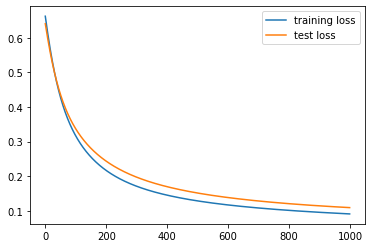

In [62]:
plt.plot(train_losses, label='training loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()

In [69]:
from sklearn.metrics import classification_report

preds = model(X_test).detach().numpy().round()
print(classification_report(preds, y_test.numpy()))

              precision    recall  f1-score   support

         0.0       0.92      0.98      0.95        61
         1.0       0.99      0.96      0.98       127

    accuracy                           0.97       188
   macro avg       0.96      0.97      0.96       188
weighted avg       0.97      0.97      0.97       188



In [71]:
# Compute accuracy

with torch.no_grad():
  p_train = model(X_train)
  p_train = np.round(p_train.numpy())
  train_acc = np.mean(y_train.numpy() == p_train)

  p_test = model(X_test)
  p_test = np.round(p_test.numpy())
  test_acc = np.mean(y_test.numpy() == p_test)

  print(f'train accuracy: {train_acc:.4f}, test accuracy: {test_acc:.4f}')

train accuracy: 0.9895, test accuracy: 0.9681


In [73]:
# Plot accuracy
